# Stochastic Analysis

## load tables

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [67]:
agents_number_df = pd.read_csv('./agents_results.csv')
agents_number_df = agents_number_df.drop_duplicates(subset='damage')
agents_number_df = agents_number_df.loc[(agents_number_df['num_agents'] >= 100) &
                                        (agents_number_df['num_agents'] <= 500) & (agents_number_df['d'] == 5) & (
                                                    agents_number_df['sigma'] == 1) & (
                                                agents_number_df['f'] == 1.5)]
agents_number_df = agents_number_df.groupby(['planner', 'num_agents'], as_index=False).mean()
agents_number_df.head()

,planner,num_agents,num_robots,f,d,sigma,active_time,planner_time,damage,num_disabled
0,StochasticAdditiveLackPlanner,100,5.0,1.5,5.0,1.0,267.268430,88.857599,23239.615267,59.018656
1,StochasticAdditiveLackPlanner,200,5.0,1.5,5.0,1.0,269.792252,236.309022,47371.664157,91.115900
2,StochasticAdditiveLackPlanner,300,5.0,1.5,5.0,1.0,268.868120,641.688411,71464.979522,116.644700
3,StochasticAdditiveLackPlanner,400,5.0,1.5,5.0,1.0,270.745241,1404.153019,96234.445304,135.973633
4,StochasticAdditiveLackPlanner,500,5.0,1.5,5.0,1.0,272.795413,2712.883743,120855.901135,155.023333


In [68]:
f_df = pd.read_csv('./f_results.csv')
f_df = f_df.drop_duplicates(subset='damage')
f_df = f_df.loc[(f_df['num_agents'] == 300) & (f_df['f'] < 2.6) & (f_df['num_robots'] == 5)]
f_df = f_df.groupby(['planner', 'f'], as_index=False).mean()
f_df.head()

,planner,f,num_agents,num_robots,d,sigma,active_time,planner_time,damage,num_disabled
0,StochasticAdditiveLackPlanner,1.1,300.0,5.0,5.0,1.0,256.664565,71.388535,81492.859781,13.981333
1,StochasticAdditiveLackPlanner,1.2,300.0,5.0,5.0,1.0,270.422775,148.645912,78593.003397,37.982933
2,StochasticAdditiveLackPlanner,1.3,300.0,5.0,5.0,1.0,277.746001,194.481347,76530.581641,65.088933
3,StochasticAdditiveLackPlanner,1.4,300.0,5.0,5.0,1.0,280.590879,153.125511,74251.897907,83.987667
4,StochasticAdditiveLackPlanner,1.5,300.0,5.0,5.0,1.0,270.276062,665.552661,71736.930662,99.609800


In [69]:
robots_df = pd.read_csv('./robots_results.csv')
robots_df = robots_df.drop_duplicates(subset=['planner', 'damage'])
robots_df = robots_df.loc[(robots_df['f'] == 1.5)]
robots_df = robots_df.groupby(['planner', 'num_robots'], as_index=False).mean()
robots_df.head()

,planner,num_robots,num_agents,f,d,sigma,active_time,planner_time,damage,num_disabled
0,StochasticAdditiveLackPlanner,2,300.0,1.5,5.0,1.0,269.204154,230.472463,73667.118142,50.2700
1,StochasticAdditiveLackPlanner,3,300.0,1.5,5.0,1.0,266.137561,393.445509,72735.432604,73.0647
2,StochasticAdditiveLackPlanner,4,300.0,1.5,5.0,1.0,268.730211,499.841525,72285.799851,94.5646
3,StochasticAdditiveLackPlanner,5,300.0,1.5,5.0,1.0,270.861559,621.103033,71768.108023,115.1926
4,StochasticAdditiveLackPlanner,6,300.0,1.5,5.0,1.0,268.886984,780.834791,71044.220021,135.7784


## visualizations

In [70]:
planners_colors = {'StochasticIterativePlanner': 'red',
                   'StochasticStaticLackPlanner': 'blue',
                   'StochasticAdditiveLackPlanner': 'orange',
                   'StochasticMonotone15LackPlanner': 'green',
                   'StochasticMonotone20LackPlanner': 'purple',
                   'StochasticMonotone30LackPlanner': 'olive',
                   'StochasticMonotone45LackPlanner': 'cyan',
                   'StochasticMonotone60LackPlanner': 'pink'}

filtered_planners_colors = {'StochasticIterativePlanner': 'red',
                   'StochasticStaticLackPlanner': 'blue',
                   'StochasticAdditiveLackPlanner': 'orange',
                   'StochasticMonotone45LackPlanner': 'cyan'}

linestyle = '-'
alpha = 0.7

In [71]:
from typing import List

displayed_labels = {'damage': 'damage (k)',
                    'completion_time': 'completion time',
                    'active_time': 'active time',
                    'planner_time': 'computation time (s)',
                    'num_disabled': 'disabled agents (%)',
                    'num_agents': 'num agents',
                    'num_robots': 'num robots',
                    'f': 'f (speed ratio)',
                    'd': 'd (disablement range)'}


def visualize(X: List[str], Y: List[str], data, file_to_save: str, title: str):
    plt.figure(figsize=(14, 10))
    plt.suptitle(title, fontsize=18)

    for i in range(len(Y)):
        x, y = X[i], Y[i]

        plt.subplot(2, 2, i + 1)
        plt.xlabel(displayed_labels[x], fontsize='14')
        plt.ylabel(displayed_labels[y], fontsize='14')
        for j in range(len(data)):
            r = data[j]

            if y == 'planner_time':
                plt.ylim([0, 3000])

            if y == 'damage':
                plt.plot(list(r[x]), [element / 1000 for element in list(r[y])], c=list(planners_colors.values())[j],
                         linestyle=linestyle, alpha=alpha)
            elif y == 'num_disabled':
                if x == 'f' or x == 'num_robots':
                    plt.plot(list(r[x]), [round(e / 300, 2) * 100 for e in list(r[y])],
                             c=list(planners_colors.values())[j], linestyle=linestyle, alpha=alpha)
                else:
                    plt.plot(list(r[x]), [round(e1 / e2, 2) * 100 for e1, e2 in zip(list(r[y]), list(r[x]))],
                             c=list(planners_colors.values())[j], linestyle=linestyle, alpha=alpha)
            else:
                plt.plot(list(r[x]), list(r[y]), c=list(planners_colors.values())[j], linestyle=linestyle, alpha=alpha)

        # if i == 2:
        #     plt.legend(planners_colors.keys(), fontsize='14', loc='center left', bbox_to_anchor=(1, 0.5))

    plt.savefig(file_to_save)
    plt.show()

In [72]:
def vis_paper(X: List[str], data, given_planners_colors):
    Y = ['damage', 'planner_time', 'num_disabled']

    for i in range(len(Y)):
        x = X[i]
        y = Y[i]

        plt.xlabel(displayed_labels[x], fontsize='14')
        plt.ylabel(displayed_labels[y], fontsize='14')
        for j in range(len(data)):
            r = data[j]

            if y == 'planner_time':
                plt.ylim([0, 5000])

            if y == 'damage':
                plt.plot(list(r[x]), [element / 1000 for element in list(r[y])], c=list(given_planners_colors.values())[j],
                         linestyle=linestyle, alpha=alpha)
            elif y == 'num_disabled':
                if x == 'f' or x == 'num_robots':
                    plt.plot(list(r[x]), [round(e / 300, 2) * 100 for e in list(r[y])],
                             c=list(given_planners_colors.values())[j], linestyle=linestyle, alpha=alpha)
                else:
                    plt.plot(list(r[x]), [round(e1 / e2, 2) * 100 for e1, e2 in zip(list(r[y]), list(r[x]))],
                             c=list(given_planners_colors.values())[j], linestyle=linestyle, alpha=alpha)
            else:
                plt.plot(list(r[x]), list(r[y]), c=list(given_planners_colors.values())[j], linestyle=linestyle, alpha=alpha)

        # if i == 2:
        #     plt.legend(given_planners_colors.keys(), fontsize='14', loc='center left', bbox_to_anchor=(1, 0.5))

        plt.savefig(f'./plots/{x}-{y}.png')
        plt.show()

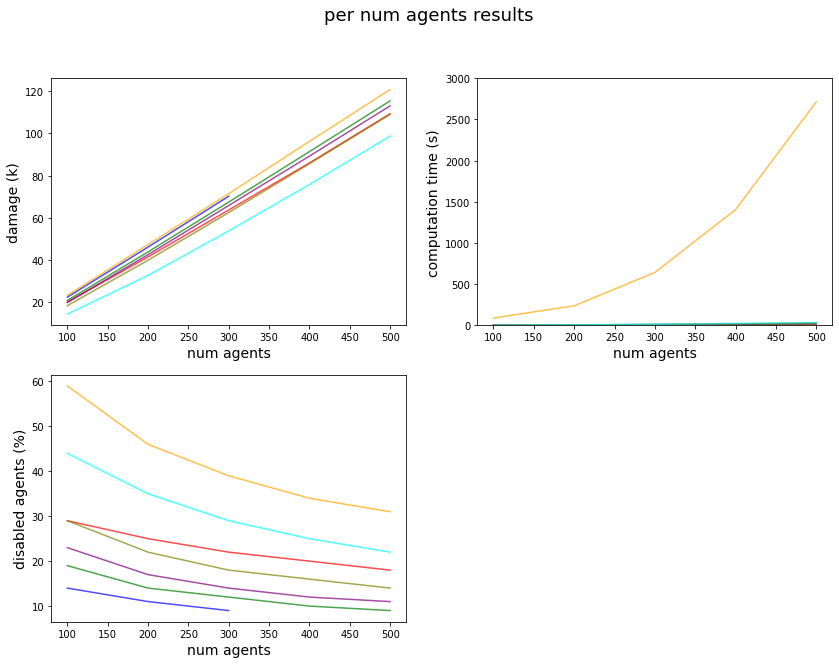

In [73]:
Y = ['damage', 'planner_time', 'num_disabled']
X = ['num_agents' for _ in Y]

agents_results = [agents_number_df.loc[agents_number_df['planner'] == name] for name in planners_colors.keys()]
title = 'per num agents results'
file_to_save = './plots/stochastic_num_agents.png'

visualize(X, Y, agents_results, file_to_save, title)

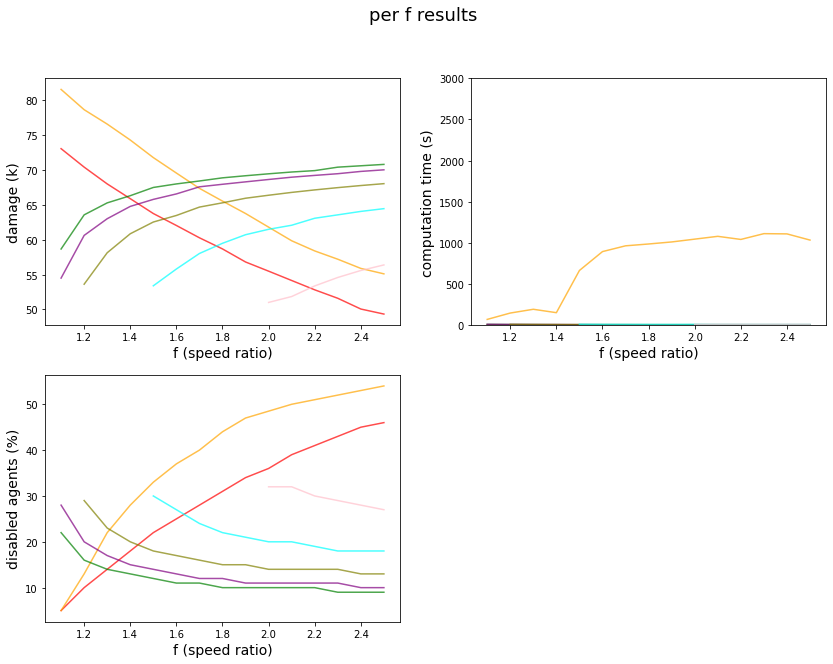

In [74]:
Y = ['damage', 'planner_time', 'num_disabled']
X = ['f' for _ in Y]

f_results = [f_df.loc[f_df['planner'] == name] for name in planners_colors.keys()]
title = 'per f results'
file_to_save = './plots/stochastic_f.png'

visualize(X, Y, f_results, file_to_save, title)

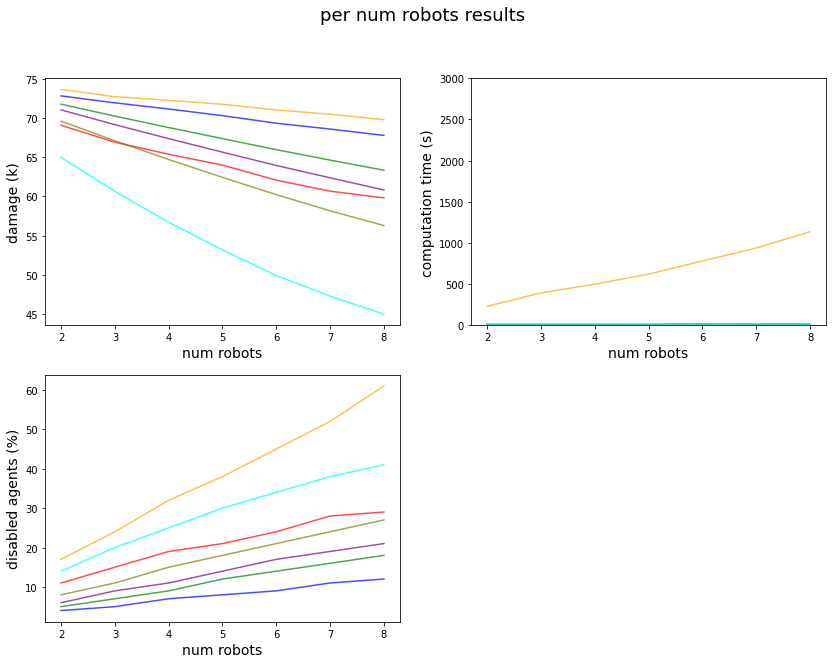

In [75]:
Y = ['damage', 'planner_time', 'num_disabled']
X = ['num_robots' for _ in Y]

robots_results = [robots_df.loc[robots_df['planner'] == name] for name in planners_colors.keys()]
title = 'per num robots results'
file_to_save = './plots/stochastic_num_robots.png'

visualize(X, Y, robots_results, file_to_save, title)

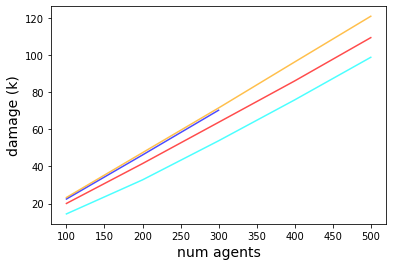

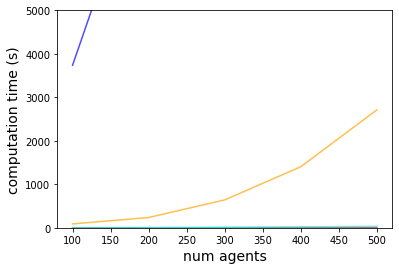

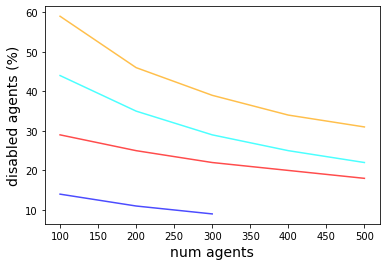

In [76]:
agents_results = [agents_number_df.loc[agents_number_df['planner'] == name] for name in filtered_planners_colors.keys()]
X = ['num_agents' for _ in Y]
vis_paper(X, agents_results, filtered_planners_colors)

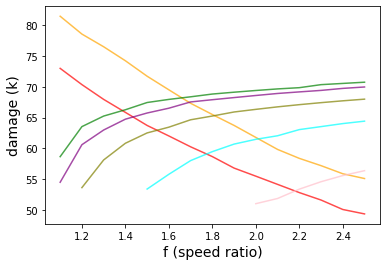

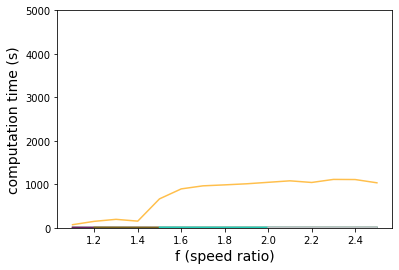

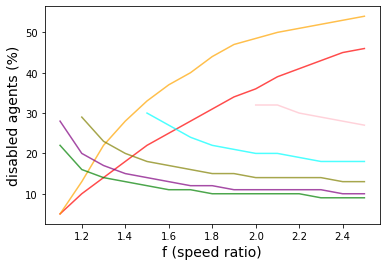

In [77]:
f_results = [f_df.loc[f_df['planner'] == name] for name in planners_colors.keys()]
X = ['f' for _ in Y]
vis_paper(X, f_results, planners_colors)

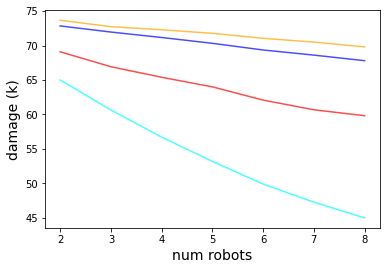

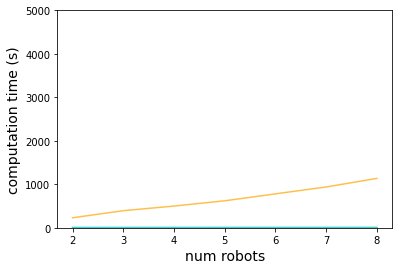

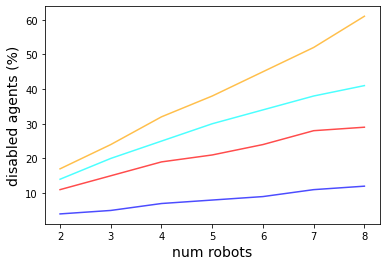

In [78]:
robots_results = [robots_df.loc[robots_df['planner'] == name] for name in filtered_planners_colors.keys()]
X = ['num_robots' for _ in Y]
vis_paper(X, robots_results, filtered_planners_colors)

## run experiments

### config file

In [14]:
import json

with open('config.json') as json_file:
    config = json.load(json_file)
config

{'x_size': 100,
 'y_size_init': 100,
 'y_size': 300,
 'x_buffer': 10,
 'y_buffer': 10,
 'num_robots': 5,
 'num_agents': 100,
 'agent_speed': 1,
 'robot_speed': 1.5,
 'disablement_range': 5,
 'sigma': 1}

In [15]:
import math
import time
from random import seed

from planners.stochastic.baseline.stochastic_iterative_planner import StochasticIterativePlanner
from planners.stochastic.partial_blockage.stochastic_additive_lack_planner import StochasticAdditiveLackPlanner
from planners.stochastic.partial_blockage.stochastic_monotone_lack_planner import StochasticMonotoneLackPlanner
from world.agents.stochastic_agent import StochasticAgent
from world.robots.timing_robot import TimingRobot
from world.stochastic_environment import StochasticEnvironment
from planners.planner import Planner
from planners.stochastic.partial_blockage.stochastic_static_lack_planner import StochasticStaticLackPlanner
from utils.functions import *

In [16]:
def run(planner: Planner, file_name: str):
    agents = [StochasticAgent(loc=sample_point(config['x_buffer'], config['x_buffer'] + config['x_size'],
                                               config['y_buffer'], config['y_buffer'] + config['y_size_init'], True),
                              v=config['agent_speed'], sigma=config['sigma']) for _ in range(config['num_agents'])]

    robots = [BasicRobot(sample_point(0, config['x_size'] + 2 * config['x_buffer'], 0, config['y_buffer'], True),
                         config['robot_speed'], config['disablement_range']) for _ in range(config['num_robots'])]

    env = StochasticEnvironment(agents=agents, robots=robots, top_border=config['y_size'] + config['y_buffer'],
                                right_border=config['x_size'] + config['x_buffer'], left_border=config['x_buffer'])

    before = time.time()
    _, active_time, expected_damage, expected_num_disabled = planner.plan(env)
    planning_time = time.time() - before

    write_report(planner=str(planner),
                 num_agents=config['num_agents'],
                 num_robots=config['num_robots'],
                 f=config['robot_speed'] / config['agent_speed'],
                 d=config['disablement_range'],
                 active_or_copmletion_time=active_time,
                 planner_time=planning_time,
                 damage=expected_damage,
                 num_disabled=expected_num_disabled,
                 file_name=file_name,
                 is_active_time=True,
                 sigma=config['sigma'])

In [48]:
planners = [StochasticStaticLackPlanner()]

for planner in planners:
    # for alpha in [math.pi / 3]:
    #     planner.alpha = alpha
    for v in tqdm([500, 400, 300]):
        print(f'*** *** v={v} *** ***')
        for s in range(1):
            seed(s)

            config['num_agents'] = v
            print(f'running {str(planner)} with seed {s}..')
            try:
                run(planner, 'agents_results.csv')
            except:
                print('pass')

  0%|          | 0/3 [00:00<?, ?it/s]

*** *** v=500 *** ***
running StochasticStaticLackPlanner with seed 0..


 33%|███▎      | 1/3 [9:03:06<18:06:12, 32586.04s/it]

pass
*** *** v=400 *** ***
running StochasticStaticLackPlanner with seed 0..


 67%|██████▋   | 2/3 [9:03:08<3:43:38, 13418.96s/it] 

pass
*** *** v=300 *** ***
running StochasticStaticLackPlanner with seed 0..


100%|██████████| 3/3 [9:03:13<00:00, 10864.50s/it]  

pass


In [16]:
# planners = [StochasticMonotoneLackPlanner(), StochasticIterativePlanner(), StochasticStaticLackPlanner(),
#             StochasticAdditiveLackPlanner()]
planners = [StochasticAdditiveLackPlanner()]

config['num_agents'] = 300

for planner in planners:
    # for alpha in [math.pi / 3, math.pi / 4, math.pi / 6, math.pi / 9, math.pi / 12]:
    #     planner.alpha = alpha
    for v in tqdm([2.5]):
        print(f'*** *** v={v} *** ***')
        for s in range(30):
            seed(s)

            config['robot_speed'] = v
            print(f'running {str(planner)} with seed {s}..')
            try:
                run(planner, 'f_results.csv')
            except:
                print('pass')

  0%|          | 0/1 [00:00<?, ?it/s]

*** *** v=2.5 *** ***
running StochasticAdditiveLackPlanner with seed 0..
running StochasticAdditiveLackPlanner with seed 1..
running StochasticAdditiveLackPlanner with seed 2..
running StochasticAdditiveLackPlanner with seed 3..
running StochasticAdditiveLackPlanner with seed 4..
running StochasticAdditiveLackPlanner with seed 5..
running StochasticAdditiveLackPlanner with seed 6..
running StochasticAdditiveLackPlanner with seed 7..
running StochasticAdditiveLackPlanner with seed 8..
running StochasticAdditiveLackPlanner with seed 9..
running StochasticAdditiveLackPlanner with seed 10..
running StochasticAdditiveLackPlanner with seed 11..
running StochasticAdditiveLackPlanner with seed 12..
running StochasticAdditiveLackPlanner with seed 13..
running StochasticAdditiveLackPlanner with seed 14..
running StochasticAdditiveLackPlanner with seed 15..
running StochasticAdditiveLackPlanner with seed 16..
running StochasticAdditiveLackPlanner with seed 17..
running StochasticAdditiveLackPlan

100%|██████████| 1/1 [8:37:18<00:00, 31038.44s/it]


In [37]:
planners = [StochasticStaticLackPlanner()]

config['num_agents'] = 300

for planner in planners:
    # for alpha in [math.pi / 3]:
    # planner.alpha = alpha
    for v in tqdm([8]):
        print(f'*** *** v={v} *** ***')
        for s in range(1):
            seed(s)

            config['num_robots'] = v
            print(f'running {str(planner)} with seed {s}..')
            run(planner, 'robots_results.csv')

  0%|          | 0/1 [00:00<?, ?it/s]

*** *** v=8 *** ***
running StochasticStaticLackPlanner with seed 0..


100%|██████████| 1/1 [14:39:05<00:00, 52745.21s/it]
